In [1]:
#not all are necessary, but are useful for debugging

#as well, there are problems with os.path that occur 
#if I don't reimport it multiple times

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import image
from PIL import Image
import os
import os.path
from os import path
import tensorflow as tf
from keras.models import Sequential, Model 
from keras.layers import *
import keras.backend as k
import keras.utils
from keras import optimizers as opt
from sklearn.model_selection import train_test_split
from keras.utils import plot_model
from keras.preprocessing.image import ImageDataGenerator
from skimage import measure
import math

print(k.image_dim_ordering())

k.set_image_dim_ordering('tf')

gpu_options = tf.GPUOptions(allow_growth=True)
session = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=gpu_options))

Using TensorFlow backend.


tf


In [2]:
def normalize(arr):
    arrMin = np.amin(arr)
    arrMax = np.amax(arr)
    print(arrMin)
    print(arrMax)
    if arrMax != 0:
        arr = np.subtract(arr,arrMin)
        #print(arr)
        arrMax = np.amax(arr)
        arr = np.divide(arr,arrMax)
        #print(arr)
    else:
        print("error, max value is zero")
    print("normalized")
    return arr

In [3]:
# Batch Generator

import keras.utils
import scipy.ndimage

batch_size=3
max_rotation_angle = 10
max_shift = 0.2
max_zoom = 0.2

class BatchGenerator(keras.utils.Sequence):
    
    def __init__(self,
                 x_set,
                 y_set,
                 batch_size,
                 image_dimensions=(128, 128, 128),
                 shuffle=True,
                 n_channels=1,
                 n_classes=2):
        self.x = x_set
        self.y = y_set
        self.batch_size = batch_size
        self.image_dimensions = image_dimensions
        print("Generator created for image size: {}".format(self.image_dimensions))
        self.shuffle = shuffle
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.number_of_images = self.x.shape[0]
        self.indices = np.arange(self.number_of_images)
        if self.shuffle == True:
            np.random.shuffle(self.indices)
            
        #print(self.x.shape)
        #print(self.y.shape)
            
    def __len__(self):
        return int(np.floor(self.number_of_images / self.batch_size))
    
    def on_epoch_end(self):
        self.indices = np.arange(self.number_of_images)
        if self.shuffle == True:
            np.random.shuffle(self.indices)
    
    def __getitem__(self, index):
        batch_indices = self.indices[index*self.batch_size : (index+1)*self.batch_size]
        x = np.empty((self.batch_size, *self.image_dimensions, self.n_channels))
        y = np.empty((self.batch_size, *self.image_dimensions))
        #print(batch_indices)
        
        for i in range(self.batch_size):
            flip_flag = np.random.randint(2)
            #print(i)
            if flip_flag == 1:
                x[i,:,:,:,:] = np.flip(self.x[batch_indices[i],:,:,:,:], axis=0)
                y[i,:,:,:]   = np.flip(self.y[batch_indices[i],:,:,:,0], axis=0)
            else:
                x[i,:,:,:,:] = self.x[batch_indices[i],:,:,:,:]
                y[i,:,:,:]   = self.y[batch_indices[i],:,:,:,0]
            
        # Rotations
        
        x_rot = np.copy(x)
        y_rot = np.copy(y)
            
        for i in range(self.batch_size):
            #print("aug",i)
            angle_x = np.random.randint(-max_rotation_angle, max_rotation_angle)
            x_rot[i,:,:,:,:] = scipy.ndimage.interpolation.rotate(
                x[i,:,:,:,:], angle_x, (1,2), False, mode="constant", cval=0, order=0)
            y_rot[i,:,:,:] = scipy.ndimage.interpolation.rotate(
                y[i,:,:,:], angle_x, (1,2), False, mode="constant", cval=0, order=0)
        
            #angle_y = np.random.randint(-max_rotation_angle, max_rotation_angle)
            #x_rot = scipy.ndimage.interpolation.rotate(x, angle_y, (0,2), False, mode="constant", cval=0, order=0)
            #y_rot = scipy.ndimage.interpolation.rotate(y, angle_y, (0,2), False, mode="constant", cval=0, order=0)

            #angle_z = np.random.randint(-max_rotation_angle, max_rotation_angle)
            #x_rot = scipy.ndimage.interpolation.rotate(x, angle_z, (0,1), False, mode="constant", cval=0, order=0)
            #y_rot = scipy.ndimage.interpolation.rotate(y, angle_z, (0,1), False, mode="constant", cval=0, order=0)
        
        # shift
        
        shift = np.random.uniform(-max_shift, max_shift, size=5)
        shift[0] = 0.0
        shift[4] = 0.0
        # x_shift = scipy.ndimage.interpolation.shift(x_rot, shift)
        # y_shift = scipy.ndimage.interpolation.shift(y_rot, shift[:4])
        
        # make sure values are between 0 and 1
        
        # x_aug = np.clip(x_shift, 0.0, 1.0)
        # y_aug = np.clip(y_shift, 0.0, 1.0)
        
        x_aug = np.clip(x_rot, 0.0, 1.0)
        y_aug = np.clip(y_rot, 0.0, 1.0)
        
        # convert segmentation to one-hot encoding
        
        y_onehot = keras.utils.to_categorical(y_aug, self.n_classes)

        return x_aug, y_onehot

In [4]:
num_classes = 2
filter_multiplier = 20

def nvidia_unet(input_size=128, num_classes=num_classes):
    input_ = Input((input_size, input_size, input_size, 1))
    skips = []
    output = input_
    c = num_classes
    
    num_layers = int(np.floor(np.log2(input_size)))
    down_conv_kernel_sizes = np.zeros([num_layers], dtype=int)
    down_filter_numbers = np.zeros([num_layers], dtype=int)
    up_conv_kernel_sizes = np.zeros([num_layers], dtype=int)
    up_filter_numbers = np.zeros([num_layers], dtype=int)
    
    for layer_index in range(num_layers):
        down_conv_kernel_sizes[layer_index] = int(3)
        down_filter_numbers[layer_index] = int( (layer_index + 1) * filter_multiplier + num_classes )
        up_conv_kernel_sizes[layer_index] = int(4)
        up_filter_numbers[layer_index] = int( (num_layers - layer_index - 1) * filter_multiplier + num_classes )
    
    print("Number of layers:       {}".format(num_layers))
    print("Filters in layers down: {}".format(down_filter_numbers))
    print("Filters in layers up:   {}".format(up_filter_numbers))
    
    for shape, filters in zip(down_conv_kernel_sizes, down_filter_numbers):
        skips.append(output)
        output= Conv3D(filters, (shape, shape, shape), strides=2, padding="same", activation="relu")(output)
        
    for shape, filters in zip(up_conv_kernel_sizes, up_filter_numbers):
        output = keras.layers.UpSampling3D()(output)
        skip_output = skips.pop()
        output = concatenate([output, skip_output], axis=4)

        if filters != num_classes:
            output = Conv3D(filters, (shape, shape, shape), activation="relu", padding="same")(output)
            output = BatchNormalization(momentum=.9)(output)
        else:
            output = Conv3D(filters, (shape, shape, shape), activation="sigmoid", padding="same")(output)
    
    assert len(skips) == 0
    return Model([input_], [output])

In [5]:
#computer specific paths
#change as needed
rootPath = "E:\\Patient Data Summer\\NN\\"
nrrdPath = "E:\\Patient Data Summer\\NN\\Nrrds\\"
segPath = "E:\\Patient Data Summer\\NN\\Segs\\"
outputPath = "E:\\Patient Data Summer\\NN\\Output\\"

nrrdFilePaths = []
nrrdFileNames = []
preNormalizedFilePaths = []
normalizedFilePaths = []
normalizedFileNames = []

labelFilePaths = []

for root, dirs, files in os.walk(nrrdPath):
        for filename in files:
            if filename.endswith("normalized.npy") or filename.endswith("5dim.npy"):
                continue
            elif filename.endswith(".npy"):
                path=os.path.join(root,filename)
                #print("found",path)
                a = np.load(path)
                nrrdFilePaths.append(path)
                #very messy, but is necessary to weed out the normalized images
                if filename.endswith("normalized.npy") or filename.endswith("5dim.npy"):
                    continue
                elif filename.endswith(".npy"):
                    noExtension = filename[:-4]
                    nrrdFileNames.append(noExtension)
                    normalizedFileNames.append(noExtension)
                    newExtension = noExtension + '_normalized.npy'
                    outPutFileName = os.path.join(root,newExtension)
                    normalizedFilePaths.append(outPutFileName)
                    
                    preNewExtension = noExtension + '_pnormalized.npy'
                    preOutputFileName = os.path.join(root,preNewExtension)
                    preNormalizedFilePaths.append(preOutputFileName)
                
print(len(nrrdFilePaths),"nrrds found")
print(len(preNormalizedFilePaths),"downsized file paths created")
print(len(normalizedFilePaths),"normalized file paths created")

95 nrrds found
95 downsized file paths created
95 normalized file paths created


In [6]:
#get labels
#I dont normalize these because they are based on binary label maps
downsizedLabelFilePaths=[]
labelFilePaths=[]
for root, dirs, files in os.walk(segPath):
        for filename in files:
            if filename.endswith("Label.npy"):                
                noExtension = filename[:-4]
                newExtension = noExtension + '_downsized.npy'
                outPutFileName = os.path.join(root,newExtension)
                downsizedLabelFilePaths.append(outPutFileName)
                
                path=os.path.join(root,filename)
                labelFilePaths.append(path)
print(len(downsizedLabelFilePaths),"downsized label paths created")

95 downsized label paths created


In [7]:
#downsize CTs
#this cell does not work unless I import these again
#not entirely sure why
import os
import os.path
from os import path
from scipy.ndimage import zoom

#preNormalized AKA downsized
imageZResize = []
nnnn=0
skippedImageDownsizeCount=0
imageDownsizeCount=0

for filePath in preNormalizedFilePaths:
    if path.exists(filePath):
        skippedImageDownsizeCount+=1
        
    elif not path.exists(filePath):
        file=nrrdFilePaths[nnnn]
        print(file)
        arr = np.load(file)
        arr = zoom(arr, (0.25,0.25,0.25))
        
        shape=arr.shape
        zAxis=(shape[0])
        resize=128/zAxis
        imageZResize.append(resize)
        arr=zoom(arr, (resize,1,1))
        print(arr.shape)
        
        np.save(filePath,arr)
        imageDownsizeCount+=1
    nnnn+=1

print(skippedImageDownsizeCount,"images skipped")
print(imageDownsizeCount,"images downsized")

95 images skipped
0 images downsized


In [8]:
#downsize labels
import os
import os.path
from os import path

labelZResize=[]
nnnnn=0
skippedLabelDownsizeCount=0
labelDownsizeCount=0

for filePath in downsizedLabelFilePaths:
    #print(e)
    if path.exists(filePath):
        skippedLabelDownsizeCount+=1
        
    elif not path.exists(filePath):
        file=labelFilePaths[nnnnn]
        print(file)
        arr = np.load(file)
        arr = zoom(arr, (0.25,0.25,0.25))
        
        shape=arr.shape
        zAxis=(shape[0])
        resize=128/zAxis
        labelZResize.append(resize)
        arr=zoom(arr, (resize,1,1))
        print(arr.shape)
        
        np.save(filePath,arr)
        labelDownsizeCount+=1
    nnnnn+=1
    
print(skippedLabelDownsizeCount,"labels skipped")
print(labelDownsizeCount,"labels downsized")

95 labels skipped
0 labels downsized


In [9]:
#create the normalized images
skippedNormalizedCount=0
normalizedCount=0

n=0
for filePath in normalizedFilePaths:
    #print(e)
    if path.exists(filePath):
        skippedNormalizedCount+=1
        
    elif not path.exists(filePath):
        file=preNormalizedFilePaths[n]
        arr = np.load(file)
        normalized = normalize(arr)
        np.save(filePath,normalized)
        normalizedCount+=1
    n+=1
    
print(skippedNormalizedCount,"scans skipped")
print(normalizedCount,"scans normalized")

95 scans skipped
0 scans normalized


In [10]:
eps = 2
smooth = 1
lam = 1

def dice_coef(y_true, y_pred):
    y_true_f = k.flatten(y_true)
    y_pred_f = k.flatten(y_pred)
    intersection = k.sum(y_true_f * y_pred_f)
    
    return (2 * intersection + smooth) / (k.sum(y_true_f) + k.sum(y_pred_f) + smooth)

def custom_binary_crossentropy(y_true,y_pred):
    #experimental binary crossentropy loss metric
    #which takes into account the amount of islands
    #not working and therefore
    #unused at the time of writing
    bc = keras.losses.binary_crossentropy(y_true, y_pred)
    islands = num_islands(bc,0)
    loss = bc*(K.log(islands+eps))**lam
    return (loss)

In [11]:
image5Dim = []
image5DimPaths = []
imageSkippedCount = 0
image5DimmedCount = 0

n1=0

for filePath in normalizedFilePaths:
    filePath = filePath[:-4]
    filePath = filePath + '_5dim.npy'
    image5DimPaths.append(filePath)

for filePath in image5DimPaths:
    if path.exists(filePath):
        arr=np.load(filePath)
        image5Dim.append(arr)
        imageSkippedCount+=1
        
    elif not path.exists(filePath):
        file=normalizedFilePaths[n1]
        print(file)
        arr=np.load(file)
        arr=arr[...,np.newaxis]
        np.save(image5DimPaths[n1],arr)
        
        print(np.shape(arr))
        image5Dim.append(arr)
        image5DimmedCount+=1
    n1+=1
    
print(imageSkippedCount,"scans skipped")
print(image5DimmedCount,"scans given an extra dimension")

95 scans skipped
0 scans given an extra dimension


In [12]:
label5Dim = []
label5DimPaths = []
label5DimmedCount = 0
labelSkippedCount = 0

n2=0

for filePath in downsizedLabelFilePaths:
    filePath = filePath[:-4]
    filePath = filePath + '_5dim.npy'
    label5DimPaths.append(filePath)

for filePath in label5DimPaths:
    if path.exists(filePath):
        arr=np.load(filePath)
        label5Dim.append(arr)
        labelSkippedCount+=1
        
    elif not path.exists(filePath):
        file=downsizedLabelFilePaths[n2]
        print(file)
        arr=np.load(file)
        arr=arr[...,np.newaxis]
        np.save(label5DimPaths[n2],arr)
        
        print(np.shape(arr))
        label5Dim.append(arr)
        label5DimmedCount +=1
    n2+=1

print(labelSkippedCount,"labels skipped")
print(label5DimmedCount,"labels given an extra dimension")

95 labels skipped
0 labels given an extra dimension


In [13]:
print(np.shape(image5Dim))
print(np.shape(label5Dim))

(95, 128, 128, 128, 1)
(95, 128, 128, 128, 1)


In [16]:
size=np.array(image5Dim).shape[1:4]

In [17]:
X_train, X_test, y_train, y_test = train_test_split (image5Dim, label5Dim, test_size = 0.01)

print(np.shape(X_train))
print(np.shape(y_train))

(94, 128, 128, 128, 1)
(94, 128, 128, 128, 1)


In [64]:
max_learning_rate = 0.001
min_learning_rate = 0.0001
num_epochs = 20

learning_rate_decay = (max_learning_rate - min_learning_rate) / num_epochs

#set initial values as very easy to beat
#so the first iteration will qualify for all of these
prev_max_acc = np.full((num_epochs), 0, dtype=int)
prev_min_acc = np.full((num_epochs), 1, dtype=int)

prev_max_loss = np.full((num_epochs), 0, dtype=int)
prev_min_loss = np.full((num_epochs), 1, dtype=int)

In [19]:
accuracyLog = []

In [20]:
import gc
gc.collect()
tf.InteractiveSession.close(session)

In [ ]:
#output hidden as it is very long
#but it has been run
for iteration in range((len(image5Dim))):
    
    import tensorflow as tf

    k.set_image_dim_ordering('tf')
    gpu_options = tf.GPUOptions(allow_growth=True)
    session = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=gpu_options))

    X_test2 = image5Dim[iteration]
    X_test2 = X_test2[np.newaxis,...]
    newImage5Dim = np.array(np.delete(image5Dim,iteration,axis=0))
    
    y_test2 = label5Dim[iteration]
    y_test2 = y_test2[np.newaxis,...]
    newLabel5Dim = np.array(np.delete(label5Dim,iteration,axis=0))
    
    
    trainingData = BatchGenerator(np.array(newImage5Dim),np.array(newLabel5Dim),image_dimensions=(size),batch_size=3)
    validationData = BatchGenerator(np.array(X_test2),np.array(y_test2),image_dimensions=(size),batch_size=1)
    
    model = nvidia_unet(size[0], num_classes)
    
    model.compile(optimizer=keras.optimizers.adam(lr=max_learning_rate, decay=learning_rate_decay),
               loss= "binary_crossentropy",
               metrics=[dice_coef])
    
    history = model.fit_generator(trainingData,
                        epochs=num_epochs,
                        verbose=2)
    
    score = model.evaluate_generator(validationData)
    
    print(score,"on loop",iteration)
    
    accuracyLog.append(score)
    
    accuracy = (score[1])
    loss = (score[0])
    
    #this is purely for generation of graphs depicting the accuracy/loss trends
    if history.history['dice_coef'][num_epochs-1] > prev_max_acc[num_epochs-1]:
        prev_max_acc = history.history['dice_coef']
        print("new max training accuracy:",history.history['dice_coef'][num_epochs-1],"max curve updated")
        
    if history.history['dice_coef'][num_epochs-1] < prev_min_acc[num_epochs-1]:
        prev_min_acc = history.history['dice_coef']
        print("new min training accuracy:",history.history['dice_coef'][num_epochs-1],"min curve updated")
        
    if history.history['loss'][num_epochs-1] > prev_max_loss[num_epochs-1]:
        prev_max_loss = history.history['loss']
        print("new max training loss:",history.history['loss'][num_epochs-1],"max loss curve updated")
        
    if history.history['loss'][num_epochs-1] < prev_min_loss[num_epochs-1]:
        prev_min_loss = history.history['loss']
        print("new min training loss:",history.history['loss'][num_epochs-1],"min loss curve updated")
    
    del history
    del model
    
    #it occasionally does not clear on the first attempt
    for e in range(5):
        gc.collect()
    k.clear_session()
    tf.InteractiveSession.close(session)
    
    #while it clogs the output, this is done so that
    #if memory runs out mid validation, it is easy to see
    #the most up to date accuracy log
    print(accuracyLog)

In [23]:
print(accuracyLog)

[[0.014259826391935349, 0.9915465712547302], [0.011529115028679371, 0.992533802986145], [0.01969677396118641, 0.9844405055046082], [0.02688632719218731, 0.9877068996429443], [0.025633931159973145, 0.9844244122505188], [0.019428284838795662, 0.9903268814086914], [0.01651676930487156, 0.9921016097068787], [0.024681217968463898, 0.9925746917724609], [0.11157740652561188, 0.9845144748687744], [0.03559790179133415, 0.9858651757240295], [0.030486587435007095, 0.9859791994094849], [0.03544504940509796, 0.9838694334030151], [0.03261465206742287, 0.9839532375335693], [0.01817402057349682, 0.9913026094436646], [0.020938143134117126, 0.9928290247917175], [0.0174013152718544, 0.9851264357566833], [0.01101470086723566, 0.9932945966720581], [0.012337010353803635, 0.9929841756820679], [0.047012846916913986, 0.974026083946228], [0.013341983780264854, 0.9914563894271851], [0.017415277659893036, 0.9910827875137329], [0.009866630658507347, 0.995201587677002], [0.014543347992002964, 0.9939191937446594], [

In [25]:
import statistics

In [26]:
#can be done in the loop itself
#therefore not fully necessary
#however I want to keep the loop as computation-light as possible

accuracies=[]
losses=[]

accuraciesTotal=0
lossesTotal=0

for i in range(len(accuracyLog)):
    isolated=accuracyLog[i]
    accuracy=isolated[1]
    loss=isolated[0]
    accuracies.append(accuracy)
    losses.append(loss)
    
    accuraciesTotal+=accuracy
    lossesTotal+=loss

averageAccuracy=accuraciesTotal/len(accuracyLog)
averageLoss=lossesTotal/len(accuracyLog)
stDevAccuracy=statistics.stdev(accuracies)
stDevLoss=statistics.stdev(losses)

maxAccuracy=np.amax(accuracies)
minAccuracy=np.amin(accuracies)
maxLoss=np.amax(losses)
minLoss=np.amin(losses)

maxAccuracyIndex = list(accuracies).index(maxAccuracy)
minAccuracyIndex = list(accuracies).index(minAccuracy)

#worst loss
maxLossIndex = list(losses).index(maxLoss)
#best loss
maxLossIndex = list(losses).index(minLoss)

print("Average accuracy:",averageAccuracy)
print("Average loss:",averageLoss)

print("stDev accuracy:",stDevAccuracy)
print("stDev loss:",stDevLoss)

print("Max accuracy:",maxAccuracy)
print("Min accuracy:",minAccuracy)
print("Max loss:",maxLoss)
print("Min loss:",minLoss)

Average accuracy: 0.9843158997987446
Average loss: 0.033212999832865436
stDev accuracy: 0.023884248070568943
stDev loss: 0.056821138617730825
Max accuracy: 0.995201587677002
Min accuracy: 0.7892768383026123
Max loss: 0.5192551016807556
Min loss: 0.009836753830313683


In [27]:
#CODE BELOW IS OPTIONAL
#and kept in purely for the generation of diagrams and visualization

In [28]:
import tensorflow as tf

k.set_image_dim_ordering('tf')
gpu_options = tf.GPUOptions(allow_growth=True)
session = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=gpu_options))

X_test2=image5Dim[maxAccuracyIndex]
X_test2=X_test2[np.newaxis,...]
newImage5Dim = np.array(np.delete(image5Dim,maxAccuracyIndex,axis=0))

y_test2 = label5Dim[maxAccuracyIndex]
y_test2=y_test2[np.newaxis,...]
newLabel5Dim = np.array(np.delete(label5Dim,maxAccuracyIndex,axis=0))


trainingData=BatchGenerator(np.array(newImage5Dim),np.array(newLabel5Dim),image_dimensions=(size),batch_size=3)
validationData=BatchGenerator(np.array(X_test2),np.array(y_test2),image_dimensions=(size),batch_size=1)

model = nvidia_unet(size[0], num_classes)

model.compile(optimizer=keras.optimizers.adam(lr=max_learning_rate, decay=learning_rate_decay),
           loss= "binary_crossentropy",
           metrics=[dice_coef])

history = model.fit_generator(trainingData,
                    epochs=num_epochs,
                    verbose=2)

score = model.evaluate_generator(validationData)

y_pred = model.predict(np.array(X_test2))

print(score)

Generator created for image size: (128, 128, 128)
Generator created for image size: (128, 128, 128)
Number of layers:       7
Filters in layers down: [ 22  42  62  82 102 122 142]
Filters in layers up:   [122 102  82  62  42  22   2]
Epoch 1/20
 - 24s - loss: 0.5134 - dice_coef: 0.6039
Epoch 2/20
 - 24s - loss: 0.1537 - dice_coef: 0.8692
Epoch 3/20
 - 25s - loss: 0.0628 - dice_coef: 0.9523
Epoch 4/20
 - 24s - loss: 0.0435 - dice_coef: 0.9709
Epoch 5/20
 - 25s - loss: 0.0364 - dice_coef: 0.9774
Epoch 6/20
 - 24s - loss: 0.0299 - dice_coef: 0.9813
Epoch 7/20
 - 24s - loss: 0.0279 - dice_coef: 0.9838
Epoch 8/20
 - 24s - loss: 0.0271 - dice_coef: 0.9842
Epoch 9/20
 - 24s - loss: 0.0261 - dice_coef: 0.9849
Epoch 10/20
 - 24s - loss: 0.0256 - dice_coef: 0.9857
Epoch 11/20
 - 24s - loss: 0.0233 - dice_coef: 0.9863
Epoch 12/20
 - 24s - loss: 0.0217 - dice_coef: 0.9872
Epoch 13/20
 - 24s - loss: 0.0215 - dice_coef: 0.9882
Epoch 14/20
 - 24s - loss: 0.0198 - dice_coef: 0.9886
Epoch 15/20
 - 25s 

In [29]:
print(score)

[0.008767526596784592, 0.9948227405548096]


In [30]:
import datetime

In [31]:
timestamp = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')

name = "model_" + timestamp + ".h5"
modelPath = os.path.join(outputPath, name)
model.save(modelPath)

In [32]:
# determine false positives and negatives
originalCT=np.array(image5Dim)
groundTruth=np.array(label5Dim)
networkSeg=np.array(y_pred)
binaryOutputSeg = (y_pred > 0.25).astype(np.uint8)
binaryOutputSeg=np.array(binaryOutputSeg)

flatFP = []
flatFN = []

flattenedGT = groundTruth[maxAccuracyIndex,:,:,:,:].flatten()
flattenedBS = binaryOutputSeg[:,:,:,:,1].flatten()

for i in range(len(flattenedGT)):
    valueGT = flattenedGT[i]
    valueBS = flattenedBS[i]
    
    #false positive
    if np.logical_and(valueBS == 1, valueGT == 0) == True:
        flatFP.append(1)
        flatFN.append(0)

    #false negative
    elif np.logical_and(valueBS == 0, valueGT == 1) == True:
        flatFN.append(1)
        flatFP.append(0)
    
    #1/1  or  0/0
    else:
        flatFN.append(0)
        flatFP.append(0)
        
falsePositives = np.array(flatFP)
falseNegatives = np.array(flatFN)
        
falsePositives = falsePositives.reshape(1,128,128,128,1)
falseNegatives = falseNegatives.reshape(1,128,128,128,1)

In [48]:
pos=80

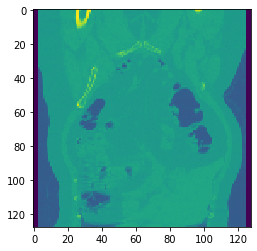

In [49]:
#Original CT

plt.imshow(originalCT[maxAccuracyIndex,:,pos,:,0])

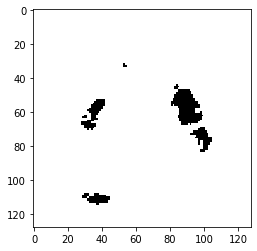

In [50]:
#Human segmentation

plt.imshow(groundTruth[maxAccuracyIndex,:,pos,:,0],cmap='Greys')

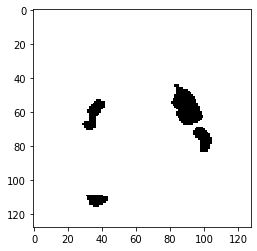

In [62]:
#binarized network output segmentation

plt.imshow(binaryOutputSeg[0,:,pos,:,1],cmap='Greys')

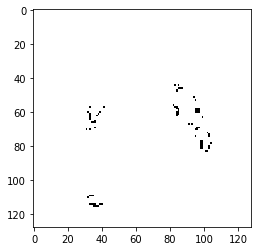

In [61]:
plt.imshow(falsePositives[0,:,pos,:,0],cmap='Greys')

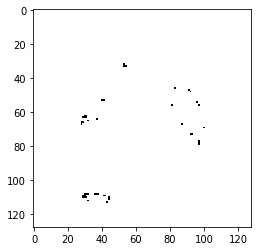

In [63]:
plt.imshow(falseNegatives[0,:,pos,:,0],cmap='Greys')

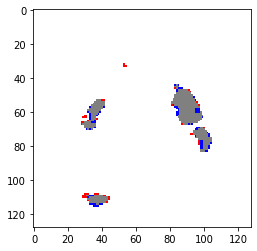

In [54]:
falsePositivesMasked = np.ma.masked_where(falsePositives == 0, falsePositives)
falseNegativesMasked = np.ma.masked_where(falseNegatives == 0, falseNegatives)

plt.imshow(binaryOutputSeg[0,:,pos,:,1],alpha=0.5,cmap='Greys')
plt.imshow(falsePositivesMasked[0,:,pos,:,0],cmap='bwr')
plt.imshow(falseNegativesMasked[0,:,pos,:,0],cmap='autumn')

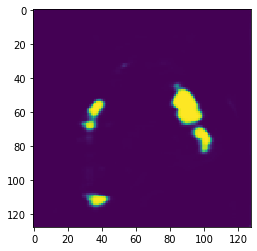

In [55]:
#Network segmentation before binarization

plt.imshow(networkSeg[0,:,pos,:,1])

In [57]:
np.save('originalCT', originalCT[maxAccuracyIndex,:,:,:,0])
np.save('groundTruth', groundTruth[maxAccuracyIndex,:,:,:,0])
np.save('binarizedNetworkSeg',binaryOutputSeg[0,:,:,:,1])
np.save('falsePositives',falsePositives[0,:,:,:,0])
np.save('falseNegatives',falseNegatives[0,:,:,:,0])

Text(0.5, 1.0, 'Training Accuracy and Loss')

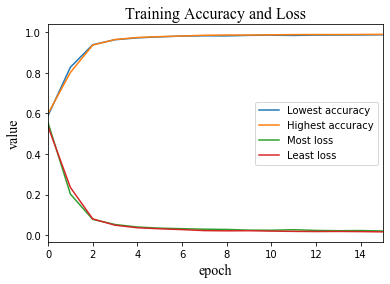

In [58]:
font = {'fontname':'Times New Roman'}

plt.plot(prev_min_acc)
plt.plot(prev_max_acc)
plt.plot(prev_max_loss)
plt.plot(prev_min_loss)
plt.ylabel('value', fontsize=14,**font)
plt.xlabel('epoch', fontsize=14,**font)
plt.xlim(0,15)
plt.legend(['Lowest accuracy','Highest accuracy','Most loss','Least loss'])
plt.title('Training Accuracy and Loss', fontsize=16,**font)

In [43]:
#TODO implement adaptive thresholding (if necessary)
#TODO clean up imports section